Loading World Bank data files...
Climate data loaded: 13566 rows
Metadata loaded: 265 countries

Finding the most recent year with good data coverage...
Year 2024: 6.4% coverage (875 non-null values)
Year 2023: 27.3% coverage (3710 non-null values)
Year 2022: 45.4% coverage (6162 non-null values)
Selected analysis year: 2022

Searching for environmental indicators...
Found 23 potential environmental indicators:
  1. Agriculture, forestry, and fishing, value added (% of GDP)
  2. Marine protected areas (% of territorial waters)
  3. Terrestrial protected areas (% of total land area)
  4. Annual freshwater withdrawals, total (% of internal resources)
  5. Annual freshwater withdrawals, total (billion cubic meters)
  6. Energy use (kg of oil equivalent per capita)
  7. Energy use (kg of oil equivalent) per $1,000 GDP (constant 2021 PPP)
  8. Renewable energy consumption (% of total final energy consumption)
  9. Electricity production from renewable sources, excluding hydroelectric (% of 

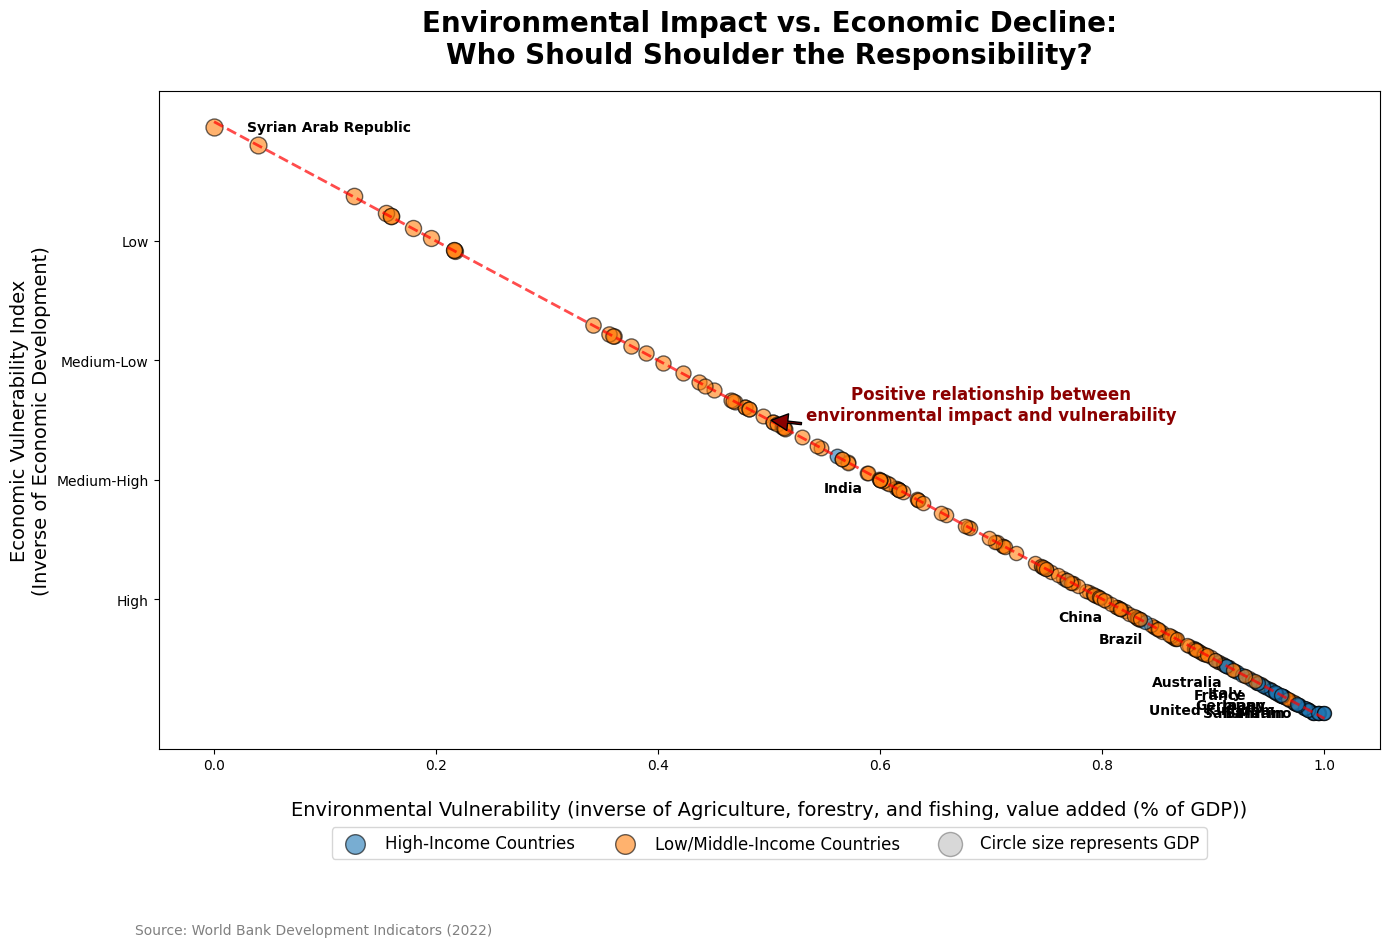

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data files
print("Loading World Bank data files...")

# Load climate data
climate_df = pd.read_csv('API_19_DS2_en_csv_v2_21028.csv', skiprows=4)
print(f"Climate data loaded: {len(climate_df)} rows")

# Load metadata
try:
    metadata_df = pd.read_csv('Metadata_Country_API_19_DS2_en_csv_v2_21028.csv')
    print(f"Metadata loaded: {len(metadata_df)} countries")
    has_metadata = True
except Exception as e:
    print(f"Error loading metadata: {e}")
    has_metadata = False

# Find the most recent year with good data coverage
print("\nFinding the most recent year with good data coverage...")
year_cols = [col for col in climate_df.columns if str(col).isdigit()]
year_cols.sort(reverse=True)  # Most recent first

analysis_year = None
for year in year_cols[:10]:  # Check the 10 most recent years
    # Check data coverage for this year
    non_null_count = climate_df[year].notna().sum()
    coverage = non_null_count / len(climate_df)
    print(f"Year {year}: {coverage:.1%} coverage ({non_null_count} non-null values)")
    
    if coverage > 0.3:  # At least 30% coverage
        analysis_year = year
        break

if not analysis_year:
    analysis_year = year_cols[0]  # Use most recent available year

print(f"Selected analysis year: {analysis_year}")

# Since we don't have CO2 emissions, let's look for another environmental indicator
print("\nSearching for environmental indicators...")
env_keywords = ['energy', 'forest', 'environment', 'land', 'agricultural', 'pollution', 
                'renewable', 'natural', 'waste', 'water']

env_indicators = []
for indicator in climate_df['Indicator Name'].unique():
    indicator_str = str(indicator).lower()
    if any(keyword in indicator_str for keyword in env_keywords):
        env_indicators.append(indicator)

print(f"Found {len(env_indicators)} potential environmental indicators:")
for i, indicator in enumerate(env_indicators[:10]):
    print(f"  {i+1}. {indicator}")

if len(env_indicators) > 10:
    print(f"  ... and {len(env_indicators) - 10} more")

# Select environmental indicator
selected_env = None
priority_indicators = [
    'forest', 'energy use', 'co2', 'methane', 'agricultural land', 
    'renewable energy', 'fossil fuel', 'electricity'
]

if env_indicators:
    # Try to find a good environmental indicator
    for priority in priority_indicators:
        for indicator in env_indicators:
            if priority in str(indicator).lower():
                selected_env = indicator
                break
        if selected_env:
            break
    
    # If no priority indicator found, use first available
    if not selected_env:
        selected_env = env_indicators[0]

if selected_env:
    print(f"\nSelected environmental indicator: {selected_env}")
    env_data = climate_df[climate_df['Indicator Name'] == selected_env]
else:
    print("No environmental indicators found.")
    exit()

# For GDP/income data
print("\nSearching for GDP/income data...")
gdp_keywords = ['gdp', 'gross domestic product', 'gni', 'gross national income', 'income']

gdp_indicators = []
for indicator in climate_df['Indicator Name'].unique():
    indicator_str = str(indicator).lower()
    if any(keyword in indicator_str for keyword in gdp_keywords):
        gdp_indicators.append(indicator)

print(f"Found {len(gdp_indicators)} potential GDP/income indicators:")
for i, indicator in enumerate(gdp_indicators[:5]):
    print(f"  {i+1}. {indicator}")

# Select GDP indicator
selected_gdp = None
if gdp_indicators:
    # Try to find total GDP or GDP per capita
    for indicator in gdp_indicators:
        if 'gdp' in str(indicator).lower() and 'capita' in str(indicator).lower():
            selected_gdp = indicator
            break
    
    # If no GDP per capita, try any GDP indicator
    if not selected_gdp:
        for indicator in gdp_indicators:
            if 'gdp' in str(indicator).lower():
                selected_gdp = indicator
                break
    
    # If still nothing, use first available
    if not selected_gdp and gdp_indicators:
        selected_gdp = gdp_indicators[0]

if selected_gdp:
    print(f"Selected GDP indicator: {selected_gdp}")
    gdp_data = climate_df[climate_df['Indicator Name'] == selected_gdp]
else:
    # If no GDP indicator, use a simple placeholder dataset
    print("No GDP indicators found. Using placeholder GDP data.")
    countries = env_data['Country Name'].unique()
    gdp_data = pd.DataFrame({
        'Country Name': countries,
        'Country Code': env_data['Country Code'].unique(),
        'Indicator Name': ['GDP placeholder'] * len(countries)
    })
    gdp_data[analysis_year] = 1000  # Set a default value

# Match countries with both environmental impact and GDP data
print("\nMatching countries with both indicators...")
countries = []
country_codes = []
env_values = []
gdp_values = []

for country in env_data['Country Name'].unique():
    country_env = env_data[env_data['Country Name'] == country]
    country_gdp = gdp_data[gdp_data['Country Name'] == country]
    
    # Check if we have data for both indicators
    if not country_env.empty and not country_gdp.empty:
        if analysis_year in country_env.columns and analysis_year in country_gdp.columns:
            env_value = country_env[analysis_year].iloc[0]
            gdp_value = country_gdp[analysis_year].iloc[0]
            
            if pd.notna(env_value) and pd.notna(gdp_value):
                countries.append(country)
                country_codes.append(country_env['Country Code'].iloc[0])
                env_values.append(env_value)
                gdp_values.append(gdp_value)

print(f"Found {len(countries)} countries with both indicators")

# Classify countries by income group if metadata is available
income_groups = []
high_income = []

if has_metadata:
    for code in country_codes:
        meta_row = metadata_df[metadata_df['Country Code'] == code]
        if not meta_row.empty and 'IncomeGroup' in meta_row.columns:
            group = meta_row['IncomeGroup'].iloc[0]
            income_groups.append(group if pd.notna(group) else 'Unknown')
            high_income.append('high' in str(group).lower() if pd.notna(group) else False)
        else:
            income_groups.append('Unknown')
            high_income.append(False)
else:
    # Use GDP as proxy for income group
    median_gdp = np.median(gdp_values)
    for gdp in gdp_values:
        income_groups.append('High income' if gdp > median_gdp else 'Low/Middle income')
        high_income.append(gdp > median_gdp)

# Convert to numpy arrays for calculations
env_array = np.array(env_values)
gdp_array = np.array(gdp_values)

# Handle zeros or negatives by setting a minimum value
env_array = np.maximum(env_array, 0.001)
gdp_array = np.maximum(gdp_array, 0.001)

# Normalize for better visualization (0-1 scale)
# For environmental impact, the meaning depends on the indicator
# For some indicators higher is worse (energy consumption), for others higher is better (forest area)
# We'll check indicator name to determine direction
indicator_name_lower = selected_env.lower()
if 'forest' in indicator_name_lower or 'renewable' in indicator_name_lower:
    # Higher is better, so invert to get "environmental impact"
    env_normalized = 1 - (env_array - np.min(env_array)) / (np.max(env_array) - np.min(env_array))
    env_label = f"Environmental Vulnerability (inverse of {selected_env})"
else:
    # Higher is worse (energy consumption, etc.)
    env_normalized = (env_array - np.min(env_array)) / (np.max(env_array) - np.min(env_array))
    env_label = f"Environmental Impact ({selected_env})"

# Normalize GDP from 0 to 1
gdp_normalized = (gdp_array - np.min(gdp_array)) / (np.max(gdp_array) - np.min(gdp_array))
gdp_normalized = np.clip(gdp_normalized, 0.01, 0.99)  # Avoid extremes of 0 or 1

# Calculate vulnerability (inverse of GDP)
vulnerability = 1 - gdp_normalized

# Create the visualization
plt.figure(figsize=(14, 10))

# Define colors for high and low income
colors = ['#1f77b4', '#ff7f0e']  # Blue for high income, orange for low/middle income

# Create scatter plot with bubble sizes based on GDP
for i in range(len(countries)):
    color = colors[0] if high_income[i] else colors[1]
    # Scale bubbles based on GDP (use log scale to avoid extreme differences)
    size = 100 + 50 * gdp_normalized[i] ** 2
    
    plt.scatter(
        env_normalized[i], 
        vulnerability[i], 
        s=size,
        color=color, 
        alpha=0.6, 
        edgecolor='black', 
        linewidth=1
    )

# Add labels for 10-15 notable countries
# Select a subset of countries to label (avoid overcrowding)
n_to_label = min(15, len(countries))
countries_to_label = []

# First add countries with extreme values
if len(countries) > 0:
    # Highest/lowest environmental impact
    max_env_idx = np.argmax(env_normalized)
    min_env_idx = np.argmin(env_normalized)
    
    # Highest/lowest vulnerability
    max_vuln_idx = np.argmax(vulnerability)
    min_vuln_idx = np.argmin(vulnerability)
    
    # Add to label list
    for idx in [max_env_idx, min_env_idx, max_vuln_idx, min_vuln_idx]:
        if countries[idx] not in countries_to_label:
            countries_to_label.append(countries[idx])

# Then add some well-known countries if they exist in the data
well_known = ['United States', 'China', 'Germany', 'Japan', 'United Kingdom', 
              'India', 'Brazil', 'France', 'Italy', 'Canada', 'Australia']

for country in well_known:
    if country in countries and country not in countries_to_label:
        countries_to_label.append(country)
        if len(countries_to_label) >= n_to_label:
            break

# Add labels for selected countries, positioning them to avoid overlap
for i, country in enumerate(countries):
    if country in countries_to_label:
        # Calculate offset direction based on position
        if env_normalized[i] < 0.5:
            x_offset = 0.03  # Place label to the right
            h_align = 'left'
        else:
            x_offset = -0.03  # Place label to the left
            h_align = 'right'
            
        plt.annotate(
            country, 
            xy=(env_normalized[i], vulnerability[i]),
            xytext=(env_normalized[i] + x_offset, vulnerability[i]),
            ha=h_align, va='center', 
            fontsize=10, 
            fontweight='bold'
        )

# Add a trend line to emphasize relationship
if len(countries) > 5:
    # Calculate correlation
    corr = np.corrcoef(env_normalized, vulnerability)[0,1]
    # Only add trend line if there's some correlation
    if abs(corr) > 0.1:
        z = np.polyfit(env_normalized, vulnerability, 1)
        p = np.poly1d(z)
        x_trend = np.linspace(0, 1, 100)
        y_trend = p(x_trend)
        plt.plot(x_trend, y_trend, 'r--', linewidth=2, alpha=0.7)
        
        # Position the annotation to the side of the trend line rather than on it
        # Calculate midpoint of the trend line
        mid_x = 0.5
        mid_y = p(mid_x)
        
        # Position the annotation to the right side of the plot
        annotation_x = 0.7  # Position it at 70% of the x-axis
        annotation_y = mid_y  # Keep the same y-level as the midpoint
        
        trend_direction = "positive" if corr > 0 else "negative"
        plt.annotate(
            f"{trend_direction.capitalize()} relationship between\nenvironmental impact and vulnerability", 
            xy=(mid_x, mid_y),  # Line points to this point on the trend line
            xytext=(annotation_x, annotation_y),  # Text positioned here
            arrowprops=dict(facecolor='darkred', shrink=0.05, width=1.5),
            color='darkred', 
            fontsize=12, 
            fontweight='bold', 
            ha='center'
        )

# Set up the axes and labels
plt.xlabel(env_label, fontsize=14, labelpad=20)  # Increased padding for x-axis label
plt.ylabel('Economic Vulnerability Index\n(Inverse of Economic Development)', fontsize=14)
plt.title('Environmental Impact vs. Economic Decline:\nWho Should Shoulder the Responsibility?', 
         fontsize=20, fontweight='bold', pad=20)

# Configure the axes
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.gca().invert_yaxis()  # Invert y-axis so higher vulnerability is at the top

# Custom y-axis labels
plt.yticks([0.2, 0.4, 0.6, 0.8], ['Low', 'Medium-Low', 'Medium-High', 'High'])

# Add legend - moved lower with bbox_to_anchor
high_income_marker = plt.scatter([], [], s=200, color=colors[0], alpha=0.6, edgecolor='black', linewidth=1)
low_income_marker = plt.scatter([], [], s=200, color=colors[1], alpha=0.6, edgecolor='black', linewidth=1)
size_marker = plt.scatter([], [], s=300, color='gray', alpha=0.3, edgecolor='black', linewidth=1)

plt.legend([high_income_marker, low_income_marker, size_marker], 
           ['High-Income Countries', 'Low/Middle-Income Countries', 'Circle size represents GDP'],
           loc='lower center', bbox_to_anchor=(0.5, -0.18), ncol=3, fontsize=12)  # Moved lower

# Add source and year
plt.figtext(0.1, 0.01, f'Source: World Bank Development Indicators ({analysis_year})',
           fontsize=10, color='gray')

plt.tight_layout(rect=[0, 0.05, 1, 0.95])

# Save the figure
plt.savefig('environmental_impact_vulnerability.png', dpi=300, bbox_inches='tight')
print("✓ Environmental impact vs. vulnerability visualization saved")
plt.show()